# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

----
----

Project by:
- Tian Cheng Xia
- Luca Domeniconi

## Initialization

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image, ImageDraw

In [2]:
# Configuration variables

DATASET_DIR = "./dataset"
TEMPLATES_DIR_NAME = "models"
SCENES_DIR_NAME = "scenes"
TEMPLATES_FILE_NAME = "ref{index}.png"
SCENE_FILE_NAME = "scene{index}.png"

SINGLE_INSTANCE_TEMPLATE_IDXS = [ *range(1, 15) ]
SINGLE_INSTANCE_SCENE_IDXS = [ *range(1, 6) ]
MULTIPLE_INSTANCES_TEMPLATE_IDXS = [ *range(15, 27) ]
MULTIPLE_INSTANCES_SCENE_IDXS = [ *range(6, 12) ]

SHOW_PLOTS = True

In [3]:
# Loading images
def loadImage(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

template_dir = os.path.join(DATASET_DIR, TEMPLATES_DIR_NAME)
scene_dir = os.path.join(DATASET_DIR, SCENES_DIR_NAME)

single_instance_templates = [ loadImage( os.path.join(template_dir, TEMPLATES_FILE_NAME.format(index=i)) ) for i in SINGLE_INSTANCE_TEMPLATE_IDXS ]
single_instance_scenes = [ loadImage( os.path.join(scene_dir, SCENE_FILE_NAME.format(index=i)) ) for i in SINGLE_INSTANCE_SCENE_IDXS ]
multi_instance_templates = [ loadImage( os.path.join(template_dir, TEMPLATES_FILE_NAME.format(index=i)) ) for i in MULTIPLE_INSTANCES_TEMPLATE_IDXS ]
multi_instance_scenes = [ loadImage( os.path.join(scene_dir, SCENE_FILE_NAME.format(index=i)) ) for i in MULTIPLE_INSTANCES_SCENE_IDXS ]

## Image filtering

We tested various combinations of filters following the rule-of-thumb of 
using a a median filter to remove salt-and-pepper noise followed by a filter to remove Gaussian noise.

In [4]:
def filter(image):
    image = cv2.medianBlur(image, 9)
    image = cv2.bilateralFilter(image, d=-1, sigmaColor=17, sigmaSpace=17)
    return image

## Single instance detection

For the single instance detection task, we employ the following workflow:

**TODO**

1. Find a candidate match in the scene.
2. Compute the density coverage of the matched keypoints in the template image.
3. Compute a confidence score based on the coverage. 
    If it is below a threshold, remove the matched area in the scene and return to point 1.
    Otherwise, consider this match as the correct match.


### Density coverage computation

To solve the problem of instances that matches only a part of the template 
(e.g. same title on the cereal box but different lower part of the box), we decided to not only count
the number of matches, but to subdivide the template in different parts, and then count how many of this parts have at least a match in the template.
In this way, a partially matched template will give a lower match score even if the number
of matches is high. In order to better subdivide the template we split it based on the density of
the detected SIFT keypoints on the template.

In [5]:
# Splits the given rect in 4 rect if there are at least k points inside it 
def split_rect(rect, points, k=5, max_depth=4):
    # Rect is a tuple of 4 points
    # rect = (upper_right, upper_left, lower_left, lower_right)
    rects = []
    
    y_min, y_max = rect[3][1], rect[0][1]
    x_min, x_max = rect[1][0], rect[0][0]
    y_med, x_med = (y_max + y_min)/2, (x_max + x_min)/2
    
    inside_points = [p for p in points if p[0] >= x_min and p[0] <= x_max and p[1] >= y_min and p[1] <= y_max]
    if len(inside_points) == 0:
        return None
    
    if max_depth == 0:
        return []
    
    if len(inside_points) > k:
        upper_right_rect = ((x_max, y_max), (x_med, y_max), (x_med, y_med), (x_max, y_med))
        upper_left_rect = ((x_med, y_max), (x_min, y_max), (x_min, y_med), (x_med, y_med))
        lower_left_rect = ((x_med, y_med), (x_min, y_med), (x_min, y_min), (x_med, y_min))
        lower_right_rect = ((x_max, y_med), (x_med, y_med), (x_med, y_min), ((x_max, y_min)))
                
        upper_right_split = split_rect(upper_right_rect, points, k, max_depth-1)
        upper_left_split = split_rect(upper_left_rect, points, k, max_depth-1)
        lower_left_split = split_rect(lower_left_rect, points, k, max_depth-1)
        lower_right_split = split_rect(lower_right_rect, points, k, max_depth-1)

        for s,r in [(upper_right_split, upper_right_rect), (upper_left_split, upper_left_rect), (lower_left_split, lower_left_rect), (lower_right_split, lower_right_rect)]:
            if s is not None:
                if len(s) > 0:
                    rects += s
                else:
                    rects += [r]
            
    return rects

![Alt text](https://i.ibb.co/fG7cwHj/output.png)

As we can see from the image above, we count the number of rects that matches the template, ignoring the size of the rect. Based on the splitting algorithm, each rect has more or less the same number of keypoint inside it.

In [6]:
def getDensity(matched_kp:list[tuple[float, float]], template_partition:list):
    match_count = { s: 0 for s in template_partition }
    
    for x_kp, y_kp in matched_kp:
        for section in template_partition:
            (x_max, y_max), (_, _), (x_min, y_min), (_, _) = section
            if (x_min <= x_kp <= x_max) and (y_min <= y_kp <= y_max):
                match_count[section] += 1
                break

    # return [s for s in template_partition if match_count[s] > 0]
    return sum([1 for s in template_partition if match_count[s] > 0]) / len(template_partition)

### Candidate match search

In [7]:
def _polygonArea(points):
    x = np.array([ pt[0] for pt in points ])
    y = np.array([ pt[1] for pt in points ])
    return 0.5 * np.abs( (x @ np.roll(y,1)) - (y @ np.roll(x,1)) )


def _areVertexesOverflowing(vertexes, image, tolerance_ratio):
    tolerance_x = image.shape[1] * tolerance_ratio
    tolerance_y = image.shape[0] * tolerance_ratio

    for point in vertexes:
        if ((point[0] > image.shape[1]+tolerance_x) or (point[0] < -tolerance_x) or 
            (point[1] > image.shape[0]+tolerance_y) or (point[1] < -tolerance_y)): 
            return True
    return False

In [8]:
def findInstance(
        scene: np.ndarray, 
        template: np.ndarray, 
        to_try_thresholds: list[float] = np.arange(0.7, 0.9, 0.05),
        overflow_tol_ratio: float = 0.15, 
        min_area_ratio: float = 0.01,
        density_threshold: float = 0.40,
        seed: int = 42
    ):
    """
        Parameters
        ----------
            scene : np.ndarray
                Scene in which the object should be found.

            template : np.ndarray
                Template of the object to match.
            
            to_try_thresholds : list[float]
                Threshold for the k-neighbors matching.

            overflow_tol_ratio : float
                TODO ...
            
            proj_min_area : float

            seed : int
                Random seed for non-deterministic functions.
        
        Returns
        -------
            object_vertexes : list[tuple[float, float]]
                Vertexes of the boundaries of the object in the scene.
    """

    sift = cv2.SIFT_create(
        contrastThreshold = 0.015,
        # edgeThreshold = 100000,
    )

    FLANN_INDEX_KDTREE = 1
    flann = cv2.FlannBasedMatcher(
        indexParams = { "algorithm": FLANN_INDEX_KDTREE, "trees": 5 },
        searchParams = { "checks": 1000 }
    )

    curr_threshold_idx = 0
    scene_area = scene.shape[0] * scene.shape[1]

    # Find and match keypoints
    kp_template = sift.detect(template)
    kp_template, desc_template = sift.compute(template, kp_template)
    kp_scene = sift.detect(scene)
    kp_scene, desc_scene = sift.compute(scene, kp_scene)

    cv2.setRNGSeed(seed)
    matches = flann.knnMatch(desc_template, desc_scene, k=2)
    
    while True:
        good_matches = [ 
            m for m, n in matches 
            if m.distance < to_try_thresholds[curr_threshold_idx]*n.distance
        ]

        template_points = np.float32([ kp_template[m.queryIdx].pt for m in good_matches ]).reshape(-1, 2)
        scene_points = np.float32([ kp_scene[m.trainIdx].pt for m in good_matches ]).reshape(-1, 2)
        
        # Find the homography from template to scene
        try:
            homography, mask = cv2.findHomography(template_points, scene_points, cv2.RANSAC, ransacReprojThreshold=20.0)
            mask = mask[:, 0] == 1
            if homography is None: raise Exception()
        except:
            curr_threshold_idx += 1
            if curr_threshold_idx >= len(to_try_thresholds): break
            continue
            
        # Compute the vertexes of the match object in the scene
        h, w, _ = template.shape
        object_vertexes = cv2.perspectiveTransform(
            src = np.float32([ [0,0], [0,h-1], [w-1,h-1], [w-1,0] ]).reshape(-1, 1, 2), 
            m = homography
        )
        object_vertexes = [pt[0] for pt in object_vertexes]

        splitted_template = split_rect(
            rect = ((h, w), (0, w), (0, 0), (h, 0)),
            points = [ (kp.pt[0], kp.pt[1]) for kp in kp_template ],
            k = 5,
            max_depth = 4
        )

        # Check if the projection is valid.
        # It is not if:
        # - it overflows too much from the borders of the image.
        criteria1 = _areVertexesOverflowing(object_vertexes, scene, overflow_tol_ratio)
        # - the area of the polygon is too small.
        criteria2 = _polygonArea(object_vertexes) < scene_area*min_area_ratio
        # - the density of the points is too low.
        criteria3 = getDensity(template_points[mask, :], splitted_template) < density_threshold
        
        if criteria1 or criteria2 or criteria3:
            curr_threshold_idx += 1
            if curr_threshold_idx >= len(to_try_thresholds): break
        else:
            return object_vertexes
        
        # Mask the found area
        img_mask = Image.new('L', (scene.shape[1], scene.shape[0]), 0)
        ImageDraw.Draw(img_mask).polygon([
            (max(0, int(pt[0])), max(0, int(pt[1]))) for pt in object_vertexes
        ], outline=1, fill=1)
        mask = np.array(img_mask)
        scene[ mask == 1, : ] = 0
        
    return None

### Complete workflow

In [9]:
def singleInstanceDetection(scene, template):
    scene = filter(scene)
    object_vertexes = findInstance(scene, template)
    return object_vertexes

### Results

Product 1 - Scene 1 - 1 instance found:
Instance 1 {position: (10, 14), width: 803px, height: 1049px}


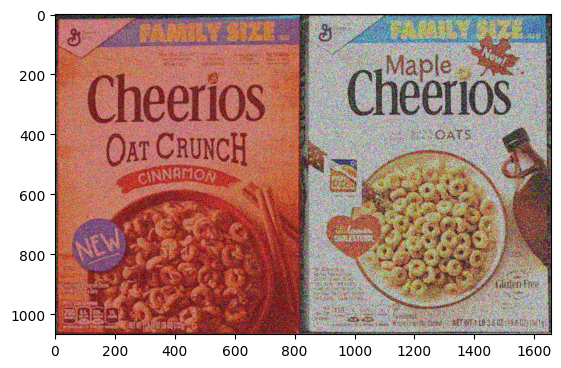


Product 2 - Scene 1 - 1 instance found:
Instance 1 {position: (846, 8), width: 802px, height: 1049px}


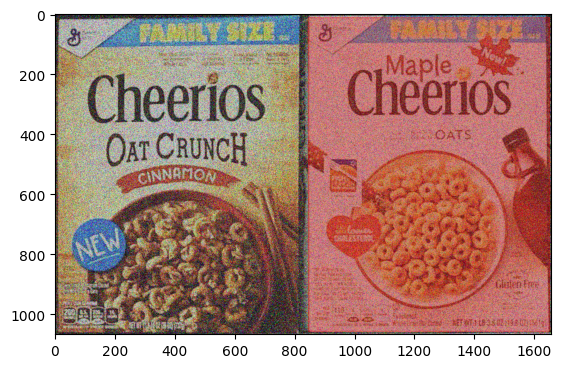


Product 3 - Scene 1 - No match found
Product 4 - Scene 1 - No match found
Product 5 - Scene 1 - No match found
Product 6 - Scene 1 - No match found
Product 7 - Scene 1 - No match found
Product 8 - Scene 1 - No match found
Product 9 - Scene 1 - No match found
Product 10 - Scene 1 - No match found
Product 11 - Scene 1 - No match found
Product 12 - Scene 1 - No match found
Product 13 - Scene 1 - No match found
Product 14 - Scene 1 - No match found
Product 1 - Scene 2 - No match found


KeyboardInterrupt: 

In [11]:
"""
We format the resulting box in order to make it a rectangle
"""
def formatResultBox(object_vertexes):
    top_left = object_vertexes[0]
    bottom_left = object_vertexes[1]
    bottom_right = object_vertexes[2]
    top_right = object_vertexes[3]

    left_x_mean = int( (top_left[0] + bottom_left[0]) / 2 )
    right_x_mean = int( (top_right[0] + bottom_right[0]) / 2 )
    top_y_mean = int( (top_left[1] + top_right[1]) / 2 )
    bottom_y_mean = int( (bottom_left[1] + bottom_right[1]) / 2 )

    return (left_x_mean, top_y_mean), right_x_mean-left_x_mean, bottom_y_mean-top_y_mean

for scene_idx, scene in zip(SINGLE_INSTANCE_SCENE_IDXS, single_instance_scenes):
    for template_idx, template in zip(SINGLE_INSTANCE_TEMPLATE_IDXS, single_instance_templates):
        object_vertexes = singleInstanceDetection(scene.copy(), template)
        if object_vertexes is None: 
            print(f"Product {template_idx} - Scene {scene_idx} - No match found")
            continue

        # TODO: No match broken

        top_left, width, height = formatResultBox(object_vertexes)

        print(f"Product {template_idx} - Scene {scene_idx} - 1 instance found:")
        print("Instance 1 {{position: {position}, width: {width}px, height: {height}px}}".format(position=top_left, width=width, height=height))

        if SHOW_PLOTS:
            plt.imshow(scene)
            plt.gca().add_patch( patches.Rectangle(top_left, width, height, linewidth=1, fill=True, alpha=0.3, color="r") )
            plt.show()
            print()

## Multiple instances detection